In [ ]:
!gdown 1kiiG1Gdt5EZWyRtM-A-V-AoNVRUUYwAY

Downloading...
From: https://drive.google.com/uc?id=1kiiG1Gdt5EZWyRtM-A-V-AoNVRUUYwAY
To: /content/archive.zip
100% 337M/337M [00:02<00:00, 145MB/s]


In [ ]:
!unzip /content/archive.zip -d /content/

Archive:  /content/archive.zip
  inflating: /content/example_submission.csv  
  inflating: /content/face_embs.npy  
  inflating: /content/fer2013.tar    
  inflating: /content/icml_face_data.csv/icml_face_data.csv  
  inflating: /content/metadata_processed.csv  
  inflating: /content/test.csv/test.csv  


## Import Packages

In [ ]:
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import cv2

import os
import random
import numpy as np
import pandas as pd
from google.colab import files
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation, Dropout, Flatten, Dense
# from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

from tqdm import tqdm

from PIL import Image

from tensorflow.keras.utils import to_categorical

## Plotly

In [ ]:
import plotly.graph_objs as go
from plotly.offline import iplot
def plot(x,y,type='scatter',title="title",xlabel="x", ylabel="y"):
    if type=='scatter':
        data = go.Scatter(x=x, y=y)
    elif type=='bar':
        data = go.Bar(x=x, y=y)

    layout = go.Layout(title=title, xaxis=dict(title=xlabel), yaxis=dict(title=ylabel))
    fig = go.Figure(data=[data], layout=layout)
    iplot(fig)

## Data I/O

In [ ]:
import tarfile

#simple function to extract the train data
#tar_file : the path to the .tar file
#path : the path where it will be extracted
def extract(tar_file, path):
    opened_tar = tarfile.open(tar_file)

    if tarfile.is_tarfile(tar_file):
        opened_tar.extractall(path)
    else:
        print("The tar file you entered is not a tar file")

# Extract data
extract("/content/fer2013.tar",".")


### Process Metadata

In [ ]:
# Read Metadata
meta_df = pd.read_csv('./fer2013/fer2013.csv')

emotions = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

meta_df = meta_df.rename(columns={"emotion":"label","pixels":"image"})
meta_df['emotion'] = meta_df['label'].apply(lambda x: emotions[int(x)])
meta_df = meta_df.drop(columns=['Usage'])

In [ ]:
list_of_class=meta_df['emotion'].factorize()[1]

In [ ]:
print(list_of_class)

Index(['Angry', 'Fear', 'Sad', 'Neutral', 'Happy', 'Surprise', 'Disgust'], dtype='object')


In [ ]:
meta_df.emotion.value_counts()

Happy       8989
Neutral     6198
Sad         6077
Fear        5121
Angry       4953
Surprise    4002
Disgust      547
Name: emotion, dtype: int64

In [ ]:
meta_df

,label,image,emotion
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Angry
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Angry
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Fear
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Sad
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Neutral
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,Neutral
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,Happy
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,Angry
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,Happy


In [ ]:
img_data = []
test_data=[]
img_label = []
test_label=[]
for i in list_of_class:
  df_new = meta_df[meta_df['emotion'] == i]
  images = df_new['image']
  emotions = df_new['label']
  traincount=0
  testcount=0
  for i in images.index:
    image = np.reshape(np.array(images[i].split(' ')).astype(int),(48,48))
    if(testcount<40):
      test_data.append(image)
      test_label.append(emotions[i])
      testcount+=1
    elif(traincount<500):
      img_data.append(image)
      img_label.append(emotions[i])
      traincount+=1
    else:
      break

In [ ]:
print(len(img_data),len(test_data))

3500 280


In [ ]:
x_train = img_data
x_train = np.asarray(x_train)
x_test=test_data
x_test= np.asarray(x_test)
print(x_train.shape,x_test.shape)
x_train_=x_train.reshape(x_train.shape[0], 48 ,48,1)
print(x_train_.shape)

(3500, 48, 48) (280, 48, 48)
(3500, 48, 48, 1)


In [ ]:
y_train = to_categorical(np.asarray(img_label))
print(y_train[3])

[1. 0. 0. 0. 0. 0. 0.]


In [ ]:
from sklearn.utils import shuffle
x_train,y_train=shuffle(x_train, y_train)

Sad


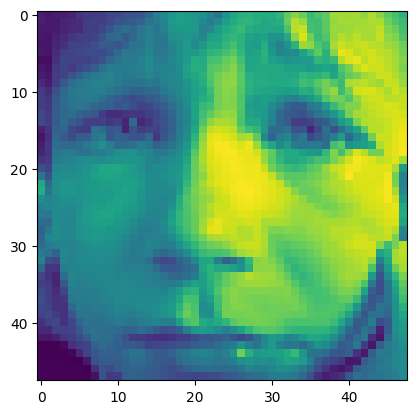

In [ ]:
# Check data
id = 6
image = np.reshape(np.array(meta_df.image[id].split(' ')).astype(int),(48,48))
plt.imshow(image)
print(meta_df.emotion[id])

In [ ]:
# Data Normalization
# Conversion to float
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
# Normalization
x_train = x_train/255.0
x_test = x_test/255.0

In [ ]:
from tensorflow.keras.layers import BatchNormalization
model=Sequential()

model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(48,48,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(Conv2D(filters=128, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(filters=256, kernel_size = (3,3), activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(512,activation="relu"))

model.add(Dense(7,activation="softmax"))

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 64)        36928     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 22, 22, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 22, 22, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 18, 18, 128)       1

In [ ]:
history = model.fit(x_train,y_train, epochs=20)

Epoch 1/20
110/110 [==============================] - 15s 15ms/step - loss: 2.6579 - accuracy: 0.2037
Epoch 2/20
110/110 [==============================] - 1s 12ms/step - loss: 1.8959 - accuracy: 0.3240
Epoch 3/20
110/110 [==============================] - 1s 11ms/step - loss: 1.5446 - accuracy: 0.4303
Epoch 4/20
110/110 [==============================] - 1s 11ms/step - loss: 1.2222 - accuracy: 0.5489
Epoch 5/20
110/110 [==============================] - 1s 11ms/step - loss: 0.8422 - accuracy: 0.7011
Epoch 6/20
110/110 [==============================] - 1s 11ms/step - loss: 0.5541 - accuracy: 0.8040
Epoch 7/20
110/110 [==============================] - 1s 11ms/step - loss: 0.2920 - accuracy: 0.9109
Epoch 8/20
110/110 [==============================] - 1s 11ms/step - loss: 0.1293 - accuracy: 0.9674
Epoch 9/20
110/110 [==============================] - 1s 11ms/step - loss: 0.0393 - accuracy: 0.9963
Epoch 10/20
110/110 [==============================] - 1s 11ms/step - loss: 0.0141 - accur

In [ ]:
model.save("rl2.h5")

In [ ]:
# Function to predict

def test_predict(test_image):
    result = model.predict(np.asarray([test_image]))

    itemindex = np.where(result==np.max(result))
    prediction = itemindex[1][0]
    # print("probability: "+str(np.max(result)*100) + "%\nPredicted class : ", list_of_class[prediction])
    return list_of_class[prediction]
    # image = img.imread(test_image)
    # plt.imshow(image)
    # plt.title(prediction)

In [ ]:
count=0;
for i in range(len(x_test)):
  print(x_test[i].shape)
  result=test_predict(x_test[i])
  if(result==list_of_class[test_label[i]]):
    count+=1;
print(count,count/len(test_data))

(48, 48)
1/1 [==============================] - 0s 250ms/step
(48, 48)
1/1 [==============================] - 0s 20ms/step
(48, 48)
1/1 [==============================] - 0s 25ms/step
(48, 48)
1/1 [==============================] - 0s 19ms/step
(48, 48)
1/1 [==============================] - 0s 17ms/step
(48, 48)
1/1 [==============================] - 0s 20ms/step
(48, 48)
1/1 [==============================] - 0s 20ms/step
(48, 48)
1/1 [==============================] - 0s 20ms/step
(48, 48)
1/1 [==============================] - 0s 20ms/step
(48, 48)
1/1 [==============================] - 0s 18ms/step
(48, 48)
1/1 [==============================] - 0s 21ms/step
(48, 48)
1/1 [==============================] - 0s 19ms/step
(48, 48)
1/1 [==============================] - 0s 24ms/step
(48, 48)
1/1 [==============================] - 0s 18ms/step
(48, 48)
1/1 [==============================] - 0s 22ms/step
(48, 48)
1/1 [==============================] - 0s 21ms/step
(48, 48)
1/1 [=========

In [ ]:
!pip install dlib


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!gdown 1uw9CGRBqEfOYaaZVdqBozmTRudROC-xu# for video funny

Downloading...
From: https://drive.google.com/uc?id=1uw9CGRBqEfOYaaZVdqBozmTRudROC-xu
To: /content/pexels-gifingcom-3694919-2160x3840-30fps.mp4
100% 72.6M/72.6M [00:01<00:00, 64.8MB/s]


In [ ]:
import cv2

# set the input and output file paths
input_file = '/content/pexels-gifingcom-3694919-2160x3840-30fps.mp4'
output_file = 'example_output.mp4'

# set the desired frame rate
desired_frame_rate = 24

# open the input video file
video_capture = cv2.VideoCapture(input_file)

# get the input video file's frame rate
frame_rate = video_capture.get(cv2.CAP_PROP_FPS)

# set the output video file's codec and frame size
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
frame_size = (int(video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))

# create the output video writer
video_writer = cv2.VideoWriter(output_file, fourcc, desired_frame_rate, frame_size)

# loop through the frames of the input video and write them to the output video
while True:
    ret, frame = video_capture.read()
    if not ret:
        break
    video_writer.write(frame)

# release the video capture and video writer objects
video_capture.release()
video_writer.release()

In [ ]:
import dlib
import cv2

def cropface(frame):
    detector = dlib.get_frontal_face_detector()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = detector(gray, 1)

    if len(faces) == 0:
        return None
    elif len(faces) == 1:
        face = faces[0]
    else:
        center_x, center_y = frame.shape[1] // 2, frame.shape[0] // 2
        dist_to_center = [(f.center().x - center_x) ** 2 + (f.center().y - center_y) ** 2 for f in faces]
        face = faces[dist_to_center.index(min(dist_to_center))]

    left, top, right, bottom = face.left(), face.top(), face.right(), face.bottom()
    return frame[top:bottom, left:right]


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

# function to generate multiple face sequences for a given movie clip
def generate_sequences(movie_path, output_dir, downsample_factor=18):
    cap = cv2.VideoCapture(movie_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    clip_duration = frame_count // fps
    frame_interval = downsample_factor // fps

    # iterate over all frame intervals
    for start_frame in range(0, downsample_factor,2):
        print(downsample_factor,start_frame)
        # set the capture frame position to the starting frame
        cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
        frames = []
        for i in range(start_frame, frame_count, downsample_factor):
            # read the next frame
            ret, frame = cap.read()
            if not ret:
                break
            # crop the face from the center of the frame using dlib or other library
            face = cropface(frame)
            # resize the face to the desired input shape of the DQN network
            if face is not None:
              if(face.shape[0]>48 and face.shape[1]>48):
                print("here")
                face = cv2.resize(face, (48, 48))
            # plt.imshow(face)
            # plt.show()
                frames.append(face)
        # save the sequence as a numpy array
        sequence = np.array(frames)
        np.save(os.path.join(output_dir, f'notfunny_{start_frame:02d}.npy'), sequence)

    cap.release()


In [ ]:
!mkdir data

In [ ]:
!gdown 1Z85M5rqw7Sx4tBdlS3QL2CjWqLs__7TH

Downloading...
From: https://drive.google.com/uc?id=1Z85M5rqw7Sx4tBdlS3QL2CjWqLs__7TH
To: /content/istockphoto-1263060144-640_adpp_is.mp4
100% 1.95M/1.95M [00:00<00:00, 203MB/s]


In [ ]:
!gdown 1MsKD7a5B9OInmGRM3-Z41g3VUfHRysch

Downloading...
From: https://drive.google.com/uc?id=1MsKD7a5B9OInmGRM3-Z41g3VUfHRysch
To: /content/tomp3.cc - See You Tomorrow for Lunch Michael   The Office US_v144P.mp4
100% 2.84M/2.84M [00:00<00:00, 233MB/s]


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
generate_sequences("/content/See You Tomorrow for Lunch, Michael!  - The Office US.mp4","./data")

In [ ]:
import numpy as np
import tensorflow as tf
from keras.callbacks import TensorBoard
from collections import deque
from tensorflow import keras

PRETRAINED = keras.models.load_model('/content/rl2.h5')

In [ ]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Model

layer_name = 'dense' # Replace with the name of the layer you want to use as embedding
embedding_model = Model(inputs=PRETRAINED.input, outputs=PRETRAINED.get_layer(layer_name).output)
img=np.asarray([x_test[0]])
# print(img)
result=embedding_model.predict(img)
print(result)

1/1 [==============================] - 0s 294ms/step
[[2.9311192e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 3.0695236e-01 3.1476040e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 1.0765123e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  1.3641312e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.1601390e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 2.7294018e+00 0.0000000e+00
  0.0000000e+00 1.0785772e+00 0.0000000e+00 1.1603382e+00 0.0000000e+00
  1.1816552e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 2.1318607e+00 7.4787626e+00 0.0000000e+00
  0.0000000e+00 0.0000000e+00 0.0000000e+00 6.8117060e-02 1.2051302e+00
  0.0000000e+00 1.3342452e+00 3.6922829e+00 2.7201411e-01 2.4281604e+00
  0.0000000e+00 0.0000000e+00 3.2888746e+00 0.0000000e+00 0.0000000e+00
  2.6183114

In [ ]:
def fill_memory(env, dqn_agent,dataset,actions):
    count=0
    for i in range(len(dataset)):
        done = False
        state = env.reset(dataset[i])

        while not done:
            # print(count)
            # count+=1
            action=np.zeros(2)
            action[actions[i]]=1.0
            next_state, reward, done, info = env.step(action,)
            # if(done):
            #   count+=1
            #   print(count)
            dqn_agent.memory.push(state=state,
                                action=action,
                                next_state=next_state,
                                reward=reward,
                                done=done)

In [ ]:
import cv2
class VideoPlayer:
    def __init__(self):
        self.current_frame = -1
        # self.action_space = [0,1]
        self.frame=None
        self.frame_count = 0

    def reset(self,squence):
        self.squence = squence
        self.current_frame = 0
        self.frame=squence[self.current_frame]
        self.frame_count = int(len(squence))
        return self.frame

    def next_frame(self):
        if self.current_frame<self.frame_count:
          self.frame=self.squence[self.current_frame]
          self.current_frame +=1

    def is_end_of_video(self):
      if(self.current_frame==self.frame_count-1):
        return True
      else:
        return False

    def step(self, action,truelabel):
      done=False
      if action == 0 and truelabel==action:
        reward = 1
        if self.is_end_of_video():
          done = True
      elif action==0 and truelabel!=action:
        reward = -1
        if self.is_end_of_video():
          done = True
      elif action==1 and truelabel==action:
        reward = 0.05
        if self.is_end_of_video():
          done = True
      elif action==1 and truelabel==action:
        reward = -0.05
        if self.is_end_of_video():
            done = True
      if(done==False):
        self.next_frame()
      return self.frame, reward, done, {}



In [ ]:
import random
from collections import deque

class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        # print("inside push====>",state,action,reward,done)
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        batch = random.sample(self.memory, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done

    def __len__(self):
        return len(self.memory)


In [ ]:

import numpy as np
from keras.layers import Input, Dense, Concatenate
# tf.disable_v2_behavior()
# import tensorflow as tf
class DQN(tf.keras.Model):
  def __init__(self, action_size,affective_size, learning_rate, name='DQN'):
    super(DQN, self).__init__()
    # tf.reset_default_graph()
    self.action_size = action_size
    self.learning_rate = learning_rate
    with tf.compat.v1.variable_scope(name):
      self.actions = tf.keras.Input(shape=(self.action_size),dtype=tf.float32, name='actions')
      self.affective = tf.keras.Input(shape=(affective_size),dtype=tf.float32, name='affactive')
      self.affective_fc1 = tf.layers.Dense(units=64, activation='relu')
      self.output1 = tf.layers.Dense(units=self.action_size, activation='linear')
      self.affective_fc2 = tf.layers.Dense( units=32, activation='relu')
      self.fused_fc1 = tf.layers.Dense(units=64,activation='relu')
      self.fused_fc2 = tf.layers.Dense(units=32,activation='relu')
  def call(self, embedding, action):
      print(action,embedding.shape)
      action=np.reshape(action,(1,2))
      # print(actions)
      x=self.affective_fc1(action)
      x=self.affective_fc2(x)
      x=Concatenate(axis=-1)([x, embedding])
      x=self.fused_fc1(x)
      x=self.fused_fc2(x)
      # Q-value output layer
      x = self.output1(x)
      # Q-value for selected action
      Q = tf.reduce_sum(tf.multiply(x, action), axis=1)
      return Q

  def predict(self, state, affective):
      return self.session.run(self.output, feed_dict={self.inputs: state, self.affective: affective})

  # def update(self, state, affective, action, target):
  #     self.session.run(feed_dict={self.inputs: state, self.affective: affective, self.actions: action, self.target_Q: target})


In [ ]:
import random
import numpy as np

import tensorflow.compat.v1 as tf

# tf.disable_v2_behavior()

class DQNAgent():

    def __init__(self, action_size=2,
                    discount=0.99,
                    eps_max=1.0,
                    eps_min=0.01,
                    eps_decay=0.995,
                    memory_capacity=1000,
                    lr=1e-3,
                    train_mode=True):

        # for epsilon-greedy exploration strategy
        self.epsilon = eps_max
        self.epsilon_min = eps_min
        self.epsilon_decay = eps_decay
        self.affective_size=2

        # for defining how far-sighted or myopic the agent should be
        self.discount = discount

        self.action_size = action_size

        # instances of the network for current policy and its target
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
        self.policy_net= DQN( self.action_size, self.affective_size, lr)
        self.target_net = DQN(self.action_size,self.affective_size, lr)
        self.policy_net.compile(loss='mse', optimizer=opt)
        self.target_net.compile(loss='mse', optimizer=opt)
        # self.target_net.eval()
        self.target_net.set_weights(self.policy_net.get_weights()) # since no learning is performed on the target net
        if not train_mode:
            self.policy_net.trainable =False
        # instance of the replay buffer
        self.memory = ReplayMemory(capacity=memory_capacity)


    def update_target_net(self):
        self.target_net.set_weights(self.policy_net.get_weights())


    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon*self.epsilon_decay)


    def select_action(self, state,action):
        state = tf.convert_to_tensor([state], dtype=tf.float32)
        if random.random() <= self.epsilon: # amount of exploration reduces with the epsilon value
            return random.randrange(self.action_size)

        # pick the action with maximum Q-value as per the policy Q-network
        action = tf.argmax(self.policy_net.call(state,action)[0]).numpy()
        print("actions=",action) # since actions are discrete, return index that has highest Q
        return action




    def learn(self, batchsize,embedding,actions1,model,next_state,true_label):

        # select n samples picked uniformly at random from the experience replay memory, such that n=batchsize
        if len(self.memory) < batchsize:
            return
        # print(memory.pop())
        # state, action, rewards, next_states, dones = self.memory.sample(batchsize)
        # get q values of the actions that were taken, i.e calculate qpred;
        # actions vector has to be explicitly reshaped to nx1-vector
        state1=np.reshape(next_state,(48,48,3))
        img= cv2.cvtColor(state1,cv2.COLOR_BGR2GRAY)
        img = img.astype("float32")
        img=img/255.0
        embd=model.predict(np.asarray([img]))
        actions=np.zeros(2)
        action=self.select_action(embd,actions1)
        actions[action]=1.0
        next_state, reward, done, info = env.step(action,true_label)
        with tf.GradientTape() as tape:
            q_pred = self.policy_net.call(embedding,actions1)
            # calculate target q-values, such that yj = rj + q(s', a'), but if current state is a terminal state, then yj = rj
            print("before")
            q_target =self.target_net.call(embd,actions)
            q_target = tf.where(done, tf.zeros_like(q_target), q_target)
            y_j = reward + (self.discount * q_target)
            y_j = tf.reshape(y_j, (-1, 1))
            # calculate the loss as the mean-squared error of yj and qpred
            loss = tf.keras.losses.MSE(y_j, q_pred)
            print("loss=" ,loss)
        gradients = tape.gradient(loss, self.policy_net.trainable_variables)
        self.policy_net.optimizer.apply_gradients(zip(gradients, self.policy_net.trainable_variables))


    def save_model(self, filename):
        self.policy_net.save_weights(filename)

    def load_model(self, filename):
        self.policy_net.load_weights(filename)




In [ ]:
# import tensorflow as tf
def train(env,dqn_agent,dataset,actions1,num_train_eps,update_frequency,batchsize,results_basepath):
  # print(actions,dataset[0].shape)
  # fill_memory(env, dqn_agen/t, dataset,actions1)
  print('Memory filled. Current capacity: ', len(dqn_agent.memory))

  reward_history = []
  epsilon_history = []

  step_cnt = 0
  best_score = -np.inf

  for ep_cnt in range(num_train_eps):
      epsilon_history.append(dqn_agent.epsilon)


      # print(dqn_agent.memory.sample(1)[3])
      for i in range(len(dataset)):
          done = False
          state =  env.reset(dataset[i])
          state1=np.reshape(state,(48,48,3))
          img= cv2.cvtColor(state1,cv2.COLOR_BGR2GRAY)
          img = img.astype("float32")
          img=img/255.0
          embd=embedding_model.predict(np.asarray([img]))
          ep_score = 0

          while not done:
              print(ep_cnt,i)
              action = dqn_agent.select_action(embd,actions1[i])
              actions=np.zeros(2)
              actions[action]=1.0
              actions=actions.astype("float32")
              next_state, reward, done, info = env.step(action,actions1[i])
              dqn_agent.memory.push(state=state, action=actions, next_state=next_state, reward=reward, done=done)
              dqn_agent.learn(batchsize=batchsize,embedding=embd,actions1=actions,model=embedding_model,next_state=next_state,true_label=actions1[i])

              if step_cnt % update_frequency == 0:
                  dqn_agent.update_target_net()

              state = next_state
              ep_score += reward
              step_cnt += 1

          dqn_agent.update_epsilon()

          reward_history.append(ep_score)
          current_avg_score = np.mean(reward_history[-100:]) # moving average of last 100 episodes

          print('Ep: {}, Total Steps: {}, Ep: Score: {}, Avg score: {}; Epsilon: {}'.format(ep_cnt,                           step_cnt, ep_score, current_avg_score, epsilon_history[-1]))

          if current_avg_score >= best_score:
              dqn_agent.save_model('{}/dqn_model'.format(results_basepath))
              best_score = current_avg_score

  with open('{}/train_reward_history.pkl'.format(results_basepath), 'wb') as f:
      pickle.dump(reward_history, f)

  with open('{}/train_epsilon_history.pkl'.format(results_basepath), 'wb') as f:
      pickle.dump(epsilon_history, f)

In [ ]:
dataset=[]
actions=[]
import os
import numpy as np
for i in os.listdir("/content/videodata"):
  if(i=="funny"):
    for j in os.listdir("/content/videodata/"+i):
      if(j.endswith("npy")):
        data=np.load("/content/videodata/"+i+"/"+j)
        dataset.append(data)
        actions.append(0)
  else:
    for j in os.listdir("/content/videodata/"+i):
      if(j.endswith("npy")):
        dataset.append(np.load("/content/videodata/"+i+"/"+j))
        actions.append(1)
env= VideoPlayer()

dqn_agent = DQNAgent()



train(env=env, dqn_agent=dqn_agent, dataset=dataset,actions1=actions,
        results_basepath="/content/output",
        num_train_eps=10,
        update_frequency=100,
        batchsize=1)



Memory filled. Current capacity:  0
1/1 [==============================] - 0s 19ms/step
0 0
1/1 [==============================] - 0s 20ms/step
[1. 0.] (1, 512)
[1. 0.] (1, 512)
loss= tf.Tensor([11.50846], shape=(1,), dtype=float32)
0 0
1/1 [==============================] - 0s 19ms/step
[1. 0.] (1, 512)
[1. 0.] (1, 512)
loss= tf.Tensor([0.10963801], shape=(1,), dtype=float32)
0 0
1/1 [==============================] - 0s 25ms/step
[0. 1.] (1, 512)
[0. 1.] (1, 512)
loss= tf.Tensor([0.33867955], shape=(1,), dtype=float32)
0 0
1/1 [==============================] - 0s 19ms/step
[0. 1.] (1, 512)
[1. 0.] (1, 512)
loss= tf.Tensor([0.02930586], shape=(1,), dtype=float32)
0 0
1/1 [==============================] - 0s 18ms/step
[1. 0.] (1, 512)
[1. 0.] (1, 512)
loss= tf.Tensor([4.5963945], shape=(1,), dtype=float32)
0 0
1/1 [==============================] - 0s 24ms/step
[0. 1.] (1, 512)
[1. 0.] (1, 512)
loss= tf.Tensor([1.6206938], shape=(1,), dtype=float32)
0 0
1/1 [=========================

ValueError: ignored

In [ ]:
!gdown 1fom-r6rM2T4qCX-umVyMqFbL9X9KVGMQ

Downloading...
From: https://drive.google.com/uc?id=1fom-r6rM2T4qCX-umVyMqFbL9X9KVGMQ
To: /content/videodata.zip
100% 5.07M/5.07M [00:00<00:00, 107MB/s]


In [ ]:
!unzip /content/videodata.zip -d /content/

Archive:  /content/videodata.zip
   creating: /content/videodata/funny/
  inflating: /content/videodata/funny/sequen_00.npy  
  inflating: /content/videodata/funny/sequen_02.npy  
  inflating: /content/videodata/funny/sequen_04.npy  
  inflating: /content/videodata/funny/sequen_06.npy  
  inflating: /content/videodata/funny/sequen_08.npy  
  inflating: /content/videodata/funny/sequen_10.npy  
  inflating: /content/videodata/funny/sequen_12.npy  
  inflating: /content/videodata/funny/sequen_14.npy  
  inflating: /content/videodata/funny/sequen_16.npy  
  inflating: /content/videodata/funny/sequenc_00.npy  
  inflating: /content/videodata/funny/sequenc_02.npy  
  inflating: /content/videodata/funny/sequenc_04.npy  
  inflating: /content/videodata/funny/sequenc_06.npy  
  inflating: /content/videodata/funny/sequenc_08.npy  
  inflating: /content/videodata/funny/sequenc_10.npy  
  inflating: /content/videodata/funny/sequenc_12.npy  
  inflating: /content/videodata/funny/sequenc_14.npy  
  

In [ ]:
def test(env, dqn_agent, num_test_eps, seed, results_basepath, render=True):

    step_cnt = 0
    reward_history = []

    for ep in range(num_test_eps):
        score = 0
        done = False
        state = env.reset()
        while not done:

            if render:
                env.render()

            action = dqn_agent.select_action(state)
            next_state, reward, done, _ = env.step(action)

            score += reward
            state = next_state
            step_cnt += 1

        reward_history.append(score)
        print('Ep: {}, Score: {}'.format(ep, score))

    with open('{}/test_reward_history_{}.pkl'.format(results_basepath, seed), 'wb') as f:
        pickle.dump(reward_history, f)

In [ ]:

for idx, seed in enumerate(args.test_seed):
    print("Testing {}/{}, seed = {}".format(idx+1, len(args.test_seed), seed))
    os.environ['PYTHONHASHSEED']=str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    env = gym.make(args.env_name)
    env.seed(seed)
    env.action_space.np_random.seed(seed)

    dqn_agent = DQNAgent(device,
                        env.observation_space.shape[0],
                        env.action_space.n,
                        discount=args.discount,
                        eps_max=0.0, # epsilon values should be zero to ensure no exploration in testing mode
                        eps_min=0.0,
                        eps_decay=0.0,
                        train_mode=False)
    dqn_agent.load_model('{}/dqn_model'.format(args.results_folder))

    test(env=env, dqn_agent=dqn_agent, num_test_eps=args.num_test_eps, seed=seed, results_basepath=args.results_folder, render=args.render)

    env.close()